In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Visualize the results of the model differencing

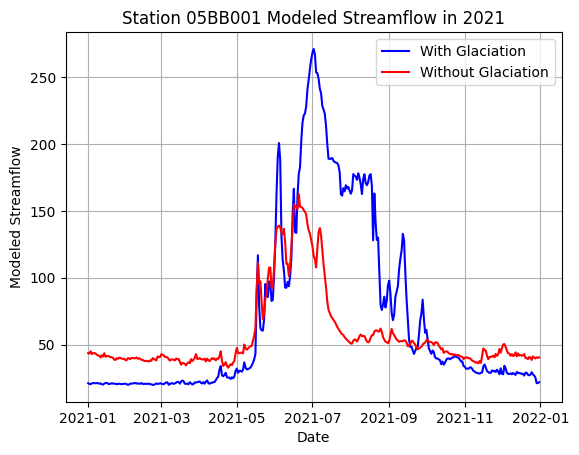

In [2]:
glac_data = pd.read_csv("modeled_streamflow_results/glaciated_predictions.csv", index_col=0)
non_glac_data = pd.read_csv("modeled_streamflow_results/non_glaciated_predictions.csv", index_col=0)
diff_data = glac_data - non_glac_data

year = 2021
glac_data.index = pd.to_datetime(glac_data.index)
non_glac_data.index = pd.to_datetime(non_glac_data.index)

glac_subset = glac_data[glac_data.index.year == year]
non_glac_subset = non_glac_data[non_glac_data.index.year == year]
diff_subset = glac_subset - non_glac_subset

station = '05DA009'

plt.plot(glac_subset.index, glac_subset[station], label='With Glaciation', color='blue')
plt.plot(non_glac_subset.index, non_glac_subset[station], label='Without Glaciation', color='red')
# plt.plot(diff_subset.index, diff_subset[station], label='Difference', color='green')
plt.plot()
plt.xlabel('Date')
plt.ylabel('Modeled Streamflow')
plt.title(f'Station 05BB001 Modeled Streamflow in {year}')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, MultiPolygon

# ---------- USER CONFIG ----------
glacier_shp = r"RGI-western-canada\02_rgi60_WesternCanadaUS.shp"
basin_shp   = r"derived_shapefiles\natural_watersheds.shp"

glacier_id_col_candidates = ["RGIId"]
basin_id_col_candidates   = ["StationNum"]

out_csv = "glacier_area_in_basin_km2.csv"

canada_albers = ("+proj=aea +lat_1=50 +lat_2=70 +lat_0=40 "
                 "+lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs")
# ----------------------------------

def find_id_column(gdf, candidates):
    cols = [c for c in candidates if c in gdf.columns]
    if cols:
        return cols[0]
    for c in gdf.columns:
        if c.lower().endswith("id"):
            return c
    raise ValueError(f"Could not find an ID column in: {list(gdf.columns)}")

def ensure_singlepart(gdf):
    return gdf.explode(ignore_index=True)

def main():
    print("Loading data...")
    g_gl = gpd.read_file(glacier_shp)
    g_bs = gpd.read_file(basin_shp)

    gid = find_id_column(g_gl, glacier_id_col_candidates)
    bid = find_id_column(g_bs, basin_id_col_candidates)

    print(f"Glacier ID column: {gid}")
    print(f"Basin ID column:   {bid}")

    # Prepare geometry
    g_gl = g_gl[g_gl.geometry.notnull()].copy()
    g_bs = g_bs[g_bs.geometry.notnull()].copy()

    g_gl['geometry'] = g_gl.buffer(0)
    g_bs['geometry'] = g_bs.buffer(0)

    g_gl = ensure_singlepart(g_gl)
    g_bs = ensure_singlepart(g_bs)

    # Reproject to Albers Equal Area (meters)
    print("Reprojecting to equal-area projection...")
    g_gl = g_gl.to_crs(canada_albers)
    g_bs = g_bs.to_crs(canada_albers)

    # Build temporary numeric indices
    g_gl['__gid'] = g_gl.index
    g_bs['__bid'] = g_bs.index

    # Spatial join for bbox intersection
    print("Finding candidate intersections...")
    possible = gpd.sjoin(
        g_gl[['__gid','geometry']],
        g_bs[['__bid','geometry']],
        how="inner",
        predicate="intersects"
    )

    print(f"Candidate intersections: {len(possible)}")

    # Compute real geometry intersections
    records = []
    for _, row in possible.iterrows():
        gidx = row['__gid']
        bidx = row['__bid']

        geom_g = g_gl.loc[gidx, 'geometry']
        geom_b = g_bs.loc[bidx, 'geometry']

        inter = geom_g.intersection(geom_b)
        if inter.is_empty:
            continue

        area_m2 = inter.area
        if area_m2 <= 0:
            continue

        records.append({
            "glacier_id": g_gl.loc[gidx, gid],
            "basin_id":   g_bs.loc[bidx, bid],
            "area_km2":   area_m2 / 1e6     # <-- convert m² → km²
        })

    if not records:
        print("No overlap found. Writing empty CSV.")
        pd.DataFrame().to_csv(out_csv)
        return

    df = pd.DataFrame(records)

    # Pivot: glacier rows, basin columns → values = area in km²
    pivot = df.pivot_table(
        index="glacier_id",
        columns="basin_id",
        values="area_km2",
        aggfunc="sum",
        fill_value=0.0
    ).sort_index().sort_index(axis=1)

    pivot.to_csv(out_csv)
    print(f"Saved glacier-area table (km²) to: {out_csv}")
    print(pivot.head())

if __name__ == "__main__":
    main()


Loading data...
Glacier ID column: RGIId
Basin ID column:   StationNum
Reprojecting to equal-area projection...
Finding candidate intersections...
Candidate intersections: 5475
Saved glacier-area table (km²) to: glacier_area_in_basin_km2.csv
basin_id        05AD003  05AD006  05AD029  05AD030  05AD031  05AD032  05AD033  \
glacier_id                                                                      
RGI60-02.01888      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
RGI60-02.02664      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
RGI60-02.03092      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
RGI60-02.03202      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
RGI60-02.03236      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

basin_id        05AE031  05AE032  05BA001  ...  07DA001  07DD001  07DD004  \
glacier_id                                 ...                              
RGI60-02.01888      0.0      0.0    

In [ ]:
import pandas as pd

# Load data
glac_data = pd.read_csv("modeled_streamflow_results/glaciated_predictions.csv", index_col=0)
study_stations = glac_data.columns.tolist()

glacier_areas = pd.read_csv("glacier_area_in_basin_km2.csv", index_col=0)
glacier_areas = glacier_areas.loc[:, study_stations]  # glacier x station

glacier_changes = pd.read_csv("ts_monthly_const_area_fnn_cluster.csv", index_col=0)
glacier_changes.index.name = "GlacierID"  # glacier x month (YYYY-MM)

# --- Step 1: Align indices ---
# Ensure glacier IDs match between the two datasets
common_glaciers = glacier_areas.index.intersection(glacier_changes.index)
glacier_areas = glacier_areas.loc[common_glaciers]
glacier_changes = glacier_changes.loc[common_glaciers]

# --- Step 2: Compute volume change ---
# Multiply glacier_changes (glacier x month) by glacier_areas (glacier x station)
# We want: (month x station) = glacier_changes.T (month x glacier) dot glacier_areas (glacier x station)

volume_changes = glacier_changes.T.dot(glacier_areas)

# --- Step 4: Clean index ---
# Convert month labels to PeriodIndex for clarity
volume_changes.index = pd.to_datetime(volume_changes.index).to_period("M")

# Result: DataFrame with rows = months, columns = stations
# units are in million cubic meters (10^6 m³)
volume_changes.to_csv("glacier_volume_change_by_station.csv")

In [38]:
SEC_PER_DAY = 86400

glac_data = pd.read_csv("modeled_streamflow_results/glaciated_predictions.csv", index_col=0)
non_glac_data = pd.read_csv("modeled_streamflow_results/non_glaciated_predictions.csv", index_col=0)

glac_data.index = pd.to_datetime(glac_data.index)
non_glac_data.index = pd.to_datetime(non_glac_data.index)
diff_volume = (glac_data - non_glac_data) * SEC_PER_DAY / 1e6 # volume in m^3 x E-6

diff_volume_monthly = diff_volume.groupby(pd.Grouper(freq="ME")).sum()

# If you want the index to show only YYYY-MM (no day component):
diff_volume_monthly.index = diff_volume_monthly.index.to_period("M")
diff_volume_monthly = diff_volume_monthly.drop("1980-12")
diff_volume_monthly = diff_volume_monthly.loc[diff_volume_monthly.sum(axis=1) != 0]

diff_volume_monthly.shape

(252, 15)

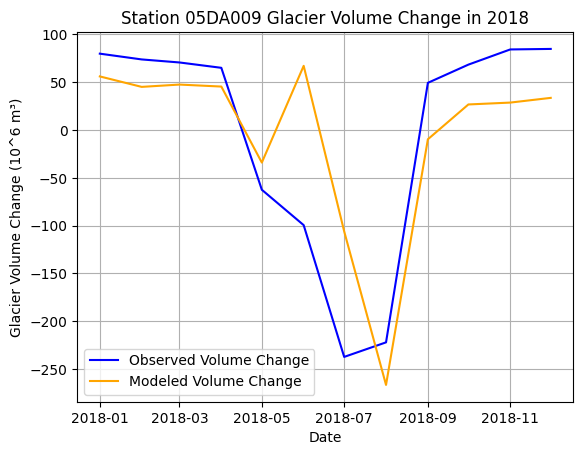

In [60]:
import matplotlib.pyplot as plt

glacier_volume_changes = pd.read_csv("glacier_volume_change_by_station.csv", index_col=0)
glacier_volume_changes.index = pd.to_datetime(glacier_volume_changes.index).to_period("M")

year = 2018
observed = glacier_volume_changes[glacier_volume_changes.index.year == year]
modeled = diff_volume_monthly[diff_volume_monthly.index.year == year]

station = study_stations[4]

# Convert PeriodIndex to Timestamp for plotting
observed_index = observed.index.to_timestamp()
modeled_index = modeled.index.to_timestamp()

plt.plot(observed_index, observed[station], label='Observed Volume Change', color='blue')
plt.plot(modeled_index, -modeled[station], label='Modeled Volume Change', color='orange')
plt.xlabel('Date')
plt.ylabel('Glacier Volume Change (10^6 m³)')
plt.title(f'Station {station} Glacier Volume Change in {year}')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\tbwil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


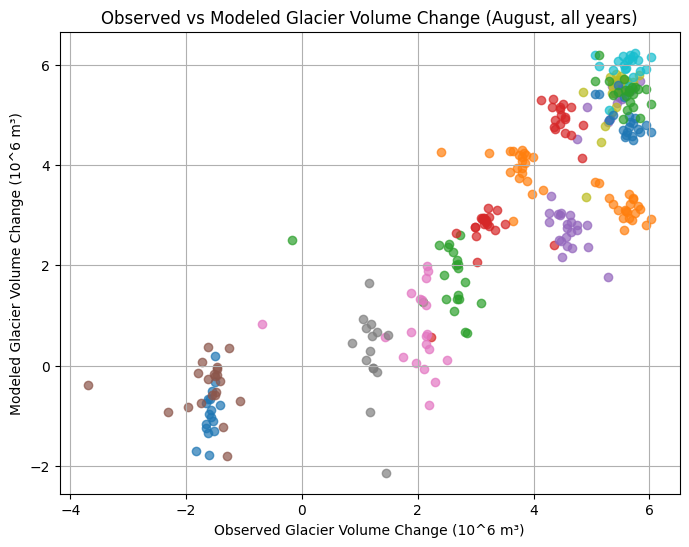

In [75]:
import matplotlib.pyplot as plt
import pandas as pd

# Load observed glacier volume changes
glacier_volume_changes = pd.read_csv("glacier_volume_change_by_station.csv", index_col=0)
glacier_volume_changes.index = pd.to_datetime(glacier_volume_changes.index).to_period("M")

study_years = diff_volume_monthly.index.year.unique()
glacier_volume_changes = glacier_volume_changes[glacier_volume_changes.index.year.isin(study_years)]

# --- Step 1: Filter to August only ---
observed_aug = glacier_volume_changes[glacier_volume_changes.index.month == 8]
modeled_aug = diff_volume_monthly[diff_volume_monthly.index.month == 8]

# --- Step 2: Loop through stations and plot scatter ---
plt.figure(figsize=(8,6))

for station in study_stations:
    plt.scatter(
        np.log(-observed_aug[station]),
        np.log(modeled_aug[station]),   # negate if modeled is opposite sign convention
        label=f"Station {station}",
        alpha=0.7
    )

plt.xlabel("Observed Glacier Volume Change (10^6 m³)")
plt.ylabel("Modeled Glacier Volume Change (10^6 m³)")
plt.title("Observed vs Modeled Glacier Volume Change (August, all years)")
# plt.legend()
plt.grid(True)
plt.show()

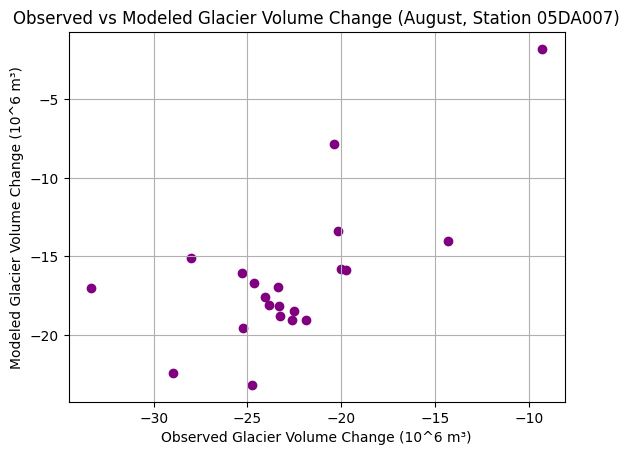

In [69]:
station = study_stations[3]
plt.scatter(observed_aug[station], -modeled_aug[station], color="purple")
plt.xlabel("Observed Glacier Volume Change (10^6 m³)")
plt.ylabel("Modeled Glacier Volume Change (10^6 m³)")
plt.title(f"Observed vs Modeled Glacier Volume Change (August, Station {station})")
plt.grid(True)
plt.show()

In [72]:
import pandas as pd
from scipy.stats import pearsonr

# --- Total correlation across all stations ---
obs_flat = observed_aug.values.flatten()
mod_flat = -modeled_aug.values.flatten()  # negate if needed

total_corr, total_pval = pearsonr(obs_flat, mod_flat)
print(f"Total correlation (all stations, August): {total_corr:.3f}, p-value: {total_pval:.3e}")

# --- Correlation per station ---
station_stats = {}
for station in study_stations:
    corr, pval = pearsonr(observed_aug[station], -modeled_aug[station])
    station_stats[station] = (corr, pval)

print("\nCorrelation per station (August):")
for st, (corr, pval) in station_stats.items():
    print(f"{st}: correlation={corr:.3f}, p-value={pval:.3e}, significant={pval < 0.05}")

Total correlation (all stations, August): 0.680, p-value: 4.483e-44

Correlation per station (August):
05AD003: correlation=0.645, p-value=1.579e-03, significant=True
05BB001: correlation=-0.369, p-value=9.978e-02, significant=False
05CA009: correlation=-0.442, p-value=4.506e-02, significant=True
05DA007: correlation=0.679, p-value=7.086e-04, significant=True
05DA009: correlation=0.634, p-value=2.019e-03, significant=True
05DA010: correlation=0.043, p-value=8.544e-01, significant=False
05DB006: correlation=-0.061, p-value=7.919e-01, significant=False
07AA001: correlation=0.356, p-value=1.129e-01, significant=False
07AA002: correlation=0.661, p-value=1.114e-03, significant=True
07AD002: correlation=0.182, p-value=4.307e-01, significant=False
07AE001: correlation=-0.594, p-value=4.489e-03, significant=True
07BE001: correlation=-0.620, p-value=2.703e-03, significant=True
07DA001: correlation=-0.517, p-value=1.645e-02, significant=True
07GA001: correlation=0.205, p-value=3.732e-01, signifi

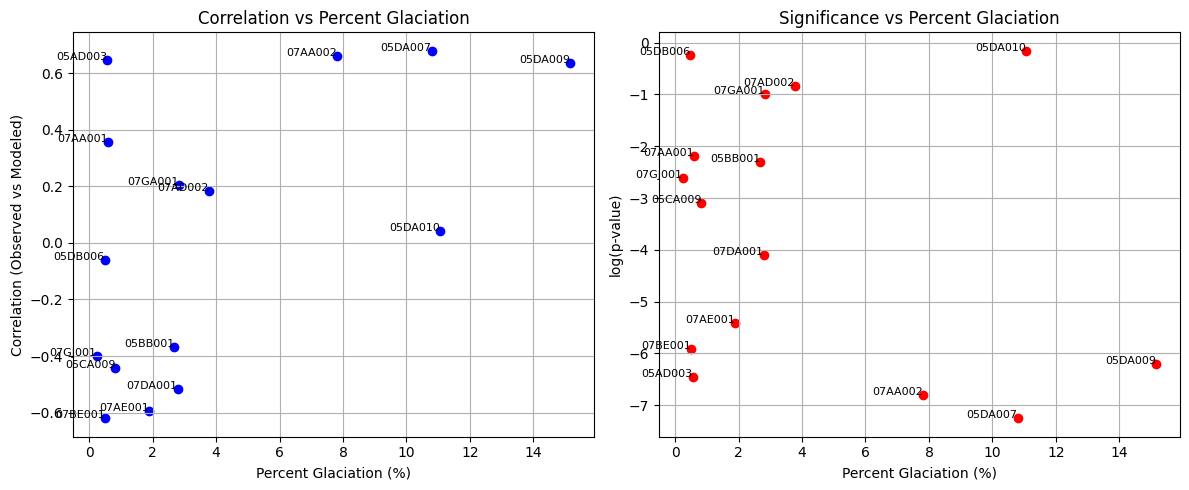

In [79]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr

# --- Compute correlations and p-values per station ---
station_corrs = []
station_pvals = []
for station in study_stations:
    corr, pval = pearsonr(observed_aug[station], -modeled_aug[station])
    station_corrs.append(corr)
    station_pvals.append(pval)

# --- Percent glaciation metadata ---
meta = pd.read_csv("station_cluster_metadata.csv", index_col=0)
meta = meta.loc[study_stations]
pct_glaciation = meta['pct_glaciation']

# --- Plot correlation vs percent glaciation ---
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(pct_glaciation, station_corrs, color='blue')
for i, st in enumerate(study_stations):
    plt.text(pct_glaciation.iloc[i], station_corrs[i], st, fontsize=8, ha='right')
plt.xlabel('Percent Glaciation (%)')
plt.ylabel('Correlation (Observed vs Modeled)')
plt.title('Correlation vs Percent Glaciation')
plt.grid(True)

# --- Plot p-value vs percent glaciation ---
plt.subplot(1,2,2)
plt.scatter(pct_glaciation, np.log(station_pvals), color='red')
for i, st in enumerate(study_stations):
    plt.text(pct_glaciation.iloc[i], np.log(station_pvals[i]), st, fontsize=8, ha='right')
plt.xlabel('Percent Glaciation (%)')
plt.ylabel('log(p-value)')
plt.title('Significance vs Percent Glaciation')
plt.grid(True)

plt.tight_layout()
plt.show()